<a href="https://colab.research.google.com/github/Afra17/BootCamp_Sdaia_DL_W4/blob/main/Project_Wee4_SDAIA_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import os
import json
from PIL import Image
from torchvision import transforms
from datasets import load_dataset
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

In [6]:
class_names = [
    "Uhud-Martyrs-Square",
    "Uhud-mounten",
    "Ghars-Well",
    "Quba-Mosque",
    "The-Prophet's-Mosque",
    "Urwah-Ibn-Az-Zubayr-Palace"
]
label2id = {name: i for i, name in enumerate(class_names)}
id2label = {i: name for i, name in enumerate(class_names)}


In [ ]:
print(label2id)

{'Uhud-Martyrs-Square': 0, 'Uhud-mounten': 1, 'Ghars-Well': 2, 'Quba-Mosque': 3, "The-Prophet's-Mosque": 4, 'Urwah-Ibn-Az-Zubayr-Palace': 5}


In [11]:
data_url = "https://github.com/Afra17/BootCamp_Sdaia_DL_W4/raw/7a803578a580ef2a14b4e2d44da51ae54f29e5fe/dataset_small%20(1).zip"
!wget "{data_url}" -O data.zip
!unzip -q data.zip -d /content/dataset_files

print("DONE")

--2026-01-09 12:32:17--  https://github.com/Afra17/BootCamp_Sdaia_DL_W4/raw/7a803578a580ef2a14b4e2d44da51ae54f29e5fe/dataset_small%20(1).zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Afra17/BootCamp_Sdaia_DL_W4/7a803578a580ef2a14b4e2d44da51ae54f29e5fe/dataset_small%20(1).zip [following]
--2026-01-09 12:32:17--  https://raw.githubusercontent.com/Afra17/BootCamp_Sdaia_DL_W4/7a803578a580ef2a14b4e2d44da51ae54f29e5fe/dataset_small%20(1).zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1385328 (1.3M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1.3

In [12]:
image_dir = "/content/dataset_files"
dataset = load_dataset("imagefolder", data_dir=image_dir, split="train")

Resolving data files:   0%|          | 0/94 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [14]:
def add_labels(example):
    path = example['image'].filename if hasattr(example['image'], 'filename') else ""
    example['labels'] = 0
    for i, name in enumerate(class_names):
        if name in path:
            example['labels'] = i
            break
    return example

dataset = dataset.map(add_labels)

Map:   0%|          | 0/94 [00:00<?, ? examples/s]

In [15]:
dataset

Dataset({
    features: ['image', 'labels'],
    num_rows: 94
})

# **Split Datasets to two (small-large)**

In [16]:
main_split = dataset.train_test_split(test_size=0.3, seed=42)
large_raw_data = main_split["train"]
small_raw_data = main_split["test"]

In [17]:
large_splits = large_raw_data.train_test_split(test_size=0.2, seed=42)
large_train_raw = large_splits["train"]
large_test_raw  = large_splits["test"]

small_splits = small_raw_data.train_test_split(test_size=0.2, seed=42)
small_train_raw = small_splits["train"]
small_test_raw  = small_splits["test"]

In [18]:
large_splits

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 52
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 13
    })
})

In [19]:
def transform_fn(examples):
    examples["pixel_values"] = [
        augmentation_transforms(img.convert("RGB")) for img in examples["image"]
    ]

    if "label" in examples:
        examples["labels"] = examples["label"]
    output_columns = ["pixel_values", "labels"]
    return {k: examples[k] for k in output_columns if k in examples}

large_train = large_train_raw.with_transform(transform_fn)
large_test  = large_test_raw.with_transform(transform_fn)


small_train = small_train_raw.with_transform(transform_fn)
small_test  = small_test_raw.with_transform(transform_fn)

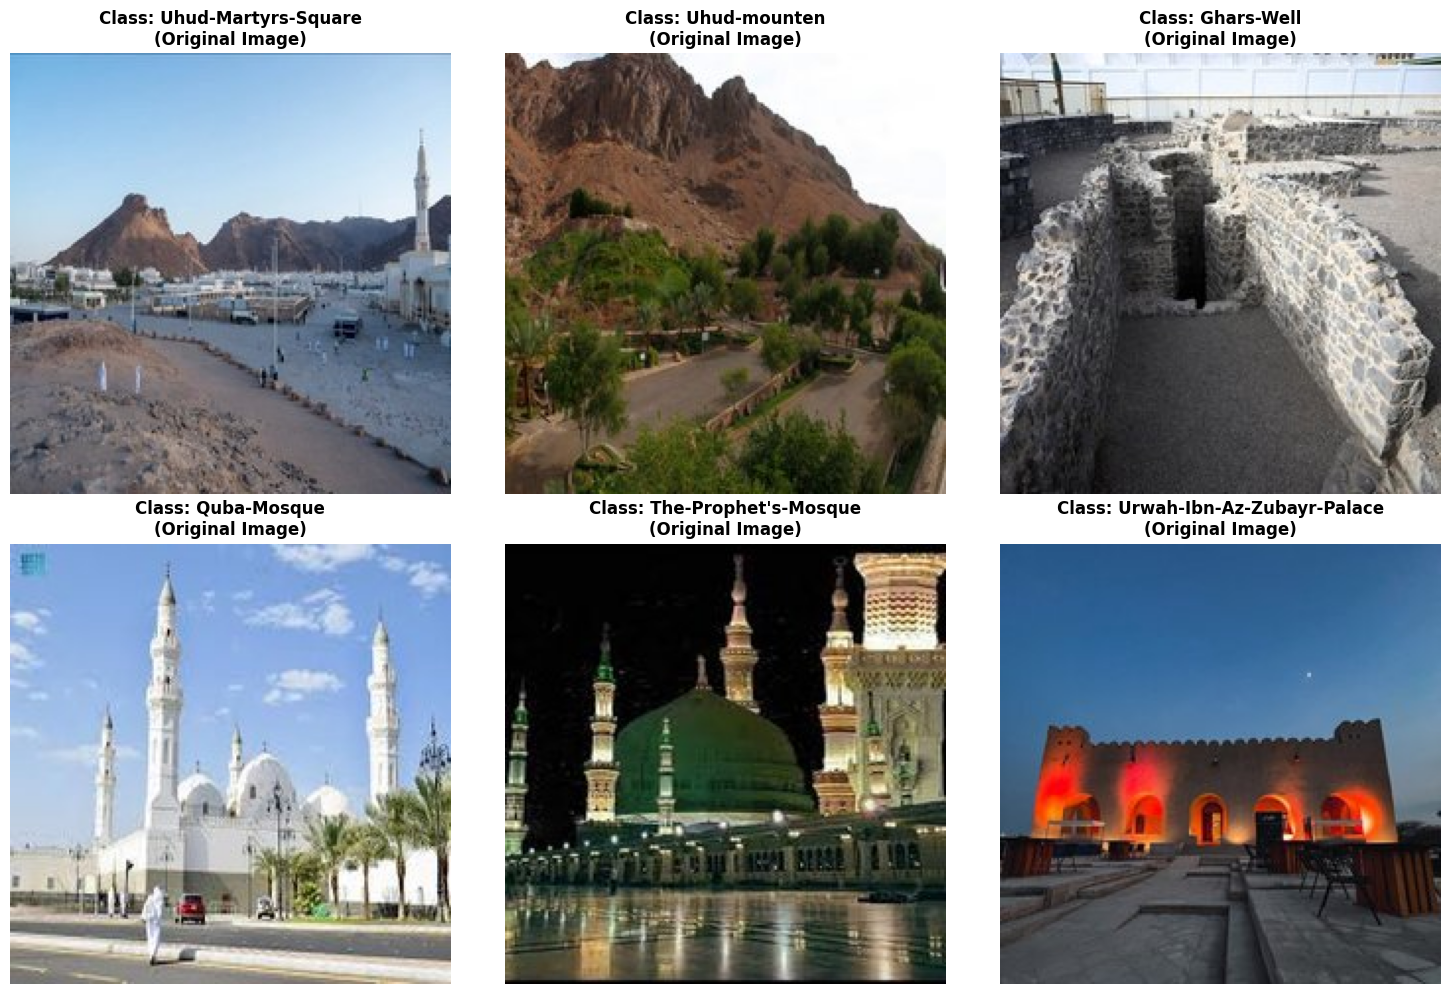

In [20]:
import matplotlib.pyplot as plt

unique_labels = sorted(list(set(main_split["train"]["labels"])))
num_classes = len(unique_labels)

cols = 3
rows = (num_classes // cols) + (1 if num_classes % cols != 0 else 0)
plt.figure(figsize=(15, rows * 5))

for i, label_id in enumerate(unique_labels):
    idx = main_split["train"]["labels"].index(label_id)

    raw_sample = main_split["train"][idx]

    img = raw_sample["image"]
    class_name = id2label[label_id]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {class_name}\n(Original Image)", fontsize=12, fontweight='bold')
    plt.axis("off")

plt.tight_layout()
plt.show()

# **Do Augmentation**

In [21]:
augmentation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

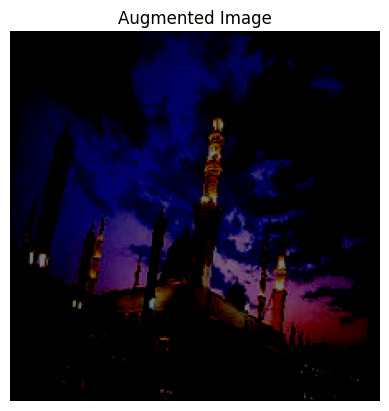

In [22]:
import matplotlib.pyplot as plt

example = large_train[5]

image_data = example["pixel_values"]

# 3. Display it
plt.imshow(image_data.permute(1, 2, 0) if hasattr(image_data, 'permute') else image_data)
plt.title("Augmented Image")
plt.axis("off")
plt.show()

# **MODEL "Vision Transformer"**




In [23]:
model_id = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_id)

model = ViTForImageClassification.from_pretrained(
    model_id,
    num_labels=len(class_names),
    id2label=id2label,
    label2id=label2id
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Full Fine-Tuning (Samll- large dataset)**

# **Large Datasets**

In [24]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00


In [25]:
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir="./vit-full-finetune",
    per_device_train_batch_size=8,
    learning_rate=2e-5,
    num_train_epochs=15,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    remove_unused_columns=False,
    logging_steps=1,
    report_to="none"
)


In [26]:
import numpy as np
import evaluate
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):

    logits, labels = eval_pred

    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

In [27]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=large_train,
    eval_dataset=large_test,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.687100,1.719196,0.384615
2,1.637600,1.672936,0.615385
3,1.497100,1.654458,0.615385
4,1.422100,1.605625,0.615385
5,1.300400,1.524944,0.692308
6,1.184800,1.516864,0.692308
7,1.132200,1.457038,0.615385
8,1.169600,1.441964,0.846154
9,0.931600,1.410679,0.769231
10,1.147400,1.395635,0.769231


TrainOutput(global_step=105, training_loss=1.2069639728182837, metrics={'train_runtime': 244.4977, 'train_samples_per_second': 3.19, 'train_steps_per_second': 0.429, 'total_flos': 6.04459188523008e+16, 'train_loss': 1.2069639728182837, 'epoch': 15.0})

# train_loss: 0.6378657621996743
# Accuracy=0.769231
-----
# train_runtime': 244.4977s




# **Small Datasets**

In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_test,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.131400,1.158757,0.833333
2,1.008900,1.155948,0.833333
3,0.956100,1.156695,0.833333
4,0.849800,1.151131,0.666667
5,0.838000,1.118642,0.833333
6,0.794300,1.089919,1.000000
7,0.831700,1.078923,0.833333
8,0.690900,1.088311,1.000000
9,0.700900,1.096749,0.833333
10,0.663600,1.082287,0.666667


TrainOutput(global_step=45, training_loss=0.8075989776187473, metrics={'train_runtime': 153.6173, 'train_samples_per_second': 2.246, 'train_steps_per_second': 0.293, 'total_flos': 2.67356948769792e+16, 'train_loss': 0.8075989776187473, 'epoch': 15.0})

# training_loss=0.8075989776187473,
# Accuracy=0.833333

------
# train_runtime': 153.6173s

 # **Perform Parameter Efficient Fine-Tuning (PEFT) by LORA**

In [29]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    modules_to_save=["classifier"]
)

model = get_peft_model(model, lora_config)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.print_trainable_parameters()

trainable params: 594,438 || all params: 86,397,708 || trainable%: 0.6880


In [30]:
training_args = TrainingArguments(
    output_dir="./medina-vit-lora-final",
    remove_unused_columns=False,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    learning_rate=1e-3,
    num_train_epochs=30,
    logging_steps=5,
    save_strategy="epoch",
    fp16=True if device == "cuda" else False,
    report_to="none"
)

# **Large Datasets**

In [31]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=large_train,
    eval_dataset=large_test,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss
5,0.685300
10,0.585800
15,0.435100
20,0.274800
25,0.301600
30,0.159000
35,0.105200
40,0.095500
45,0.073500
50,0.044700


TrainOutput(global_step=390, training_loss=0.042409273294302136, metrics={'train_runtime': 51.3831, 'train_samples_per_second': 30.36, 'train_steps_per_second': 7.59, 'total_flos': 1.2172936641675264e+17, 'train_loss': 0.042409273294302136, 'epoch': 30.0})

# training_loss=0.02864039983504858
-----
# train_runtime: 110.2336s


# **Small Datasets**

In [32]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_test,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss
5,0.008200
10,0.002800
15,0.002000
20,0.008400
25,0.001000
30,0.001100
35,0.000900
40,0.000900
45,0.000800
50,0.000700


TrainOutput(global_step=180, training_loss=0.0009836134015737722, metrics={'train_runtime': 15.287, 'train_samples_per_second': 45.136, 'train_steps_per_second': 11.775, 'total_flos': 5.384183514587136e+16, 'train_loss': 0.0009836134015737722, 'epoch': 30.0})

# training_loss=0.0009836134015737722
-----
# train_runtime: 15.287s